# Example for making plots from processor output

This example takes the output of the SS_analysis processor, but should be rather general.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from processor.SS_analysis import *
from Tools.config_helpers import *
from klepto.archives import dir_archive

In [9]:
# the equivalent code can be run with ipython -i SS_analysis.py within the processor directory

from Tools.samples import * # fileset_2018 #, fileset_2018_small
from processor.std_acumulators import *

overwrite = False

# load the config and the cache
cfg = loadConfig()

cacheName = 'SS_analysis'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
histograms = sorted(list(desired_output.keys()))

year = 2018



fileset = {
    #'inclusive': glob.glob('/home/users/dspitzba/TTW/CMSSW_10_2_9/src/inclusive_1000.root'),
    #'plus': glob.glob('/home/users/dspitzba/TTW/CMSSW_10_2_9/src/plus_2000.root'),
    #'topW_v2': fileset_2018['topW_v2'], # verified that v2 and v3 are similar, v3 has more stats!
    'topW_v3': fileset_2018['topW_v3'],
    'TTW': fileset_2018['TTW'],
    'TTZ': fileset_2018['TTZ'],
    'TTH': fileset_2018['TTH'],
    'ttbar': fileset_2018['ttbar'],
}


exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    
    output = processor.run_uproot_job(
        fileset,
        "Events",
        SS_analysis(year=year, variations=variations, accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )
    
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()




## Cutflow example

In [10]:
from Tools.helpers import getCutFlowTable

processes = [
    'topW_v3',
    'TTW', 'TTZ', 'TTH', 'ttbar',
]
lines = ['entry']
lines += ['lepveto', 'dilep', 'SS', 'filter', 'p_T(lep0)>25', 'p_T(lep1)>20', ]
lines += ['N_jet>3', 'N_central>2', 'N_btag>0', 'N_fwd>0', 'N_jet>4', 'N_central>3', 'ST', 'MET>50', 'delta_eta', 'fwd_p>500', 'p_T(lep0)>40', 'p_T(lep1)>30']
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='topW_v3')
df


,topW_v3,TTW,TTZ,TTH,ttbar,S/B
entry,226.3 +/- 0.2,15200.0 +/- 30.0,12400.0 +/- 10.0,11630.0 +/- 10.0,11590000.0 +/- 0.0,0.0000
lepveto,119.7 +/- 0.2,3747.0 +/- 13.0,5268.0 +/- 6.0,2739.0 +/- 3.0,2647000.0 +/- 1000.0,0.0000
dilep,46.45 +/- 0.11,1319.0 +/- 7.0,2391.0 +/- 4.0,811.0 +/- 1.7,834000.0 +/- 300.0,0.0001
SS,35.18 +/- 0.09,433.9 +/- 2.0,151.0 +/- 0.9,209.4 +/- 0.8,1860.0 +/- 23.0,0.0133
filter,35.14 +/- 0.09,433.5 +/- 2.0,150.8 +/- 0.9,209.2 +/- 0.8,1859.0 +/- 23.0,0.0132
p_T(lep0)>25,34.74 +/- 0.09,429.1 +/- 2.0,148.2 +/- 0.9,205.1 +/- 0.8,1789.0 +/- 22.0,0.0135
p_T(lep1)>20,31.82 +/- 0.09,391.9 +/- 1.9,132.6 +/- 0.8,180.5 +/- 0.7,1418.0 +/- 18.0,0.0150
N_jet>3,28.48 +/- 0.08,262.5 +/- 1.6,87.75 +/- 0.69,133.1 +/- 0.6,566.8 +/- 10.9,0.0271
N_central>2,27.7 +/- 0.08,251.2 +/- 1.6,80.29 +/- 0.67,128.6 +/- 0.6,508.1 +/- 10.0,0.0286
N_btag>0,25.16 +/- 0.08,229.2 +/- 1.5,72.4 +/- 0.63,114.4 +/- 0.6,423.7 +/- 9.0,0.0300


In [11]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,ttbar
entry,1.0000,1.0000,1.0000,1.0000,1.0000
lepveto,0.5287,0.2466,0.4247,0.2356,0.2283
dilep,0.3882,0.3520,0.4540,0.2961,0.3151
SS,0.7574,0.3290,0.0632,0.2582,0.0022
filter,0.9989,0.9991,0.9984,0.9988,0.9996
p_T(lep0)>25,0.9884,0.9897,0.9831,0.9803,0.9620
p_T(lep1)>20,0.9159,0.9135,0.8947,0.8801,0.7926
N_jet>3,0.8951,0.6696,0.6616,0.7372,0.3998
N_central>2,0.9725,0.9572,0.9149,0.9661,0.8966
N_btag>0,0.9083,0.9124,0.9018,0.8900,0.8338


## Plot example

We redefine a few axes to make plots with a more reasonable binning (remember that we chose to define histograms with a high number of bins, and then just rebin later - that later is now!).



In [12]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import makePlot
import re

bkgonly = re.compile('(?!(MuonEG))')

N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins = hist.Bin('eta', r'$\eta $', 25, -5.0, 5.0)

Data: 0 MC: 100.83


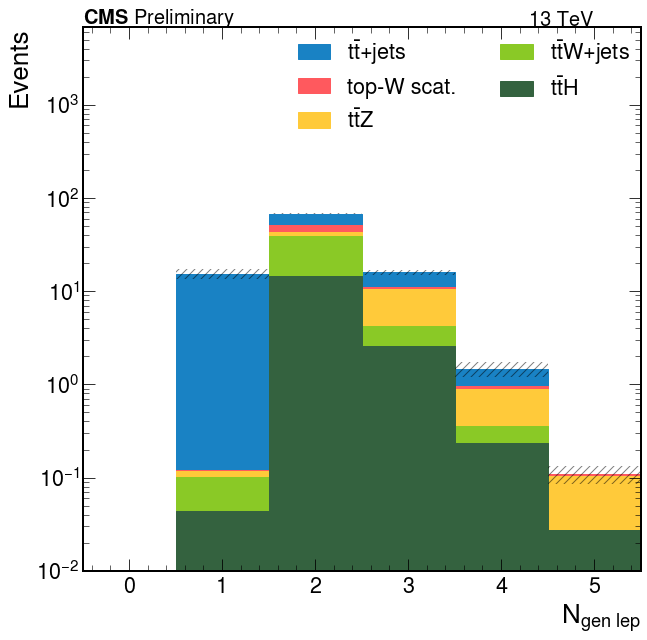

In [13]:
makePlot(output, 'nGenL', 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{gen\ lep}$',
        )


Data: 0 MC: 100.83
Figure saved in: /home/users/dspitzba/public_html/tW_scattering/dump/test/nGenL


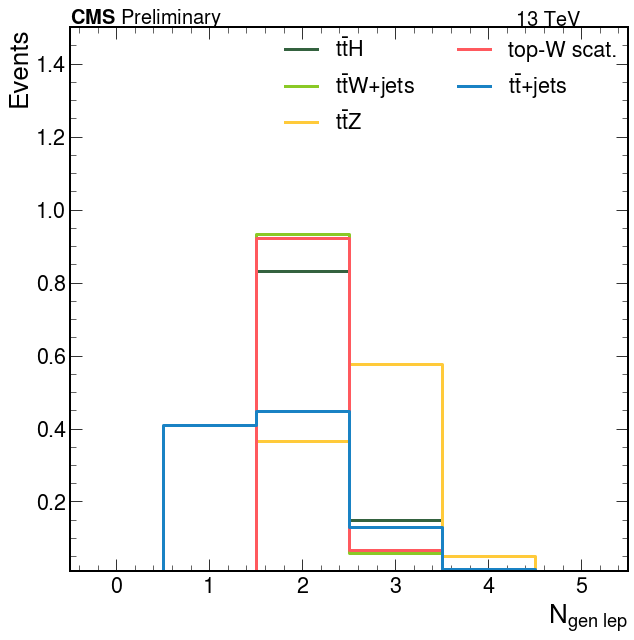

In [23]:
makePlot(output, 'nGenL', 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=False, normalize=False, axis_label=r'$N_{gen\ lep}$',
         shape=True, ymax=1.5,
         save='/home/users/dspitzba/public_html/tW_scattering/dump/test/nGenL'
        )